# Project Report: Optimizing Alzheimer’s Classification via Block-Wise CNN Fine-Tuning

**Author:** Tessa Saumu
**Date:** February 2026
**Project Type:** Medical Imaging / Computer Vision

## 1. Executive Summary

This project focuses on the multi-class classification of Alzheimer’s Disease stages using MRI scans. Building upon an initial baseline model (ResNet50, ~89% accuracy), this iteration aimed to address specific limitations regarding precision in early-stage detection and model robustness.

By implementing a **rigorous data splitting pipeline**, a **medically-relevant preprocessing strategy**, and **Block-Wise Fine-Tuning** architecture search, the final model (**DenseNet121**) achieved a test accuracy of **99.83%**.

### Key Achievements
*   **Performance:** Increased overall accuracy from 89% (baseline) to **99.83%** (final).
*   **Methodology:** Shifted from random layer freezing to architectural **Block-Wise Fine-Tuning**.
*   **Robustness:** Identified and resolved a critical conflict between standard ImageNet preprocessing and medical MRI intensity distributions.
*   **Clinical Relevance:** Achieved **99-100% Recall** across all classes, minimizing the risk of missed diagnoses.

## 2. Problem Statement & Evolution

### The Challenge
Alzheimer's MRI datasets often suffer from varying intensity scales due to different scanner protocols. Standard CNNs trained on natural images (ImageNet) expect specific lighting and color distributions. Directly applying these models often leads to sub-optimal generalization.

### Evolution from Previous Iteration
My initial attempt yielded promising results (89% accuracy) but highlighted several flaws:
1.  **Precision/Recall Trade-off:** The model struggled to distinguish `VeryMildDemented` from `NonDemented`.
2.  **Black Box Training:** Layers were frozen/unfrozen arbitrarily without respect to the model's internal block structure.
3.  **Input Scaling:** Standard scaling failed to account for the unique intensity histograms of MRI scans.

**New Objectives:**
*   Implement **Per-Image Robust Normalization** (IQR-based).
*   Compare three architectures: **ResNet50**, **EfficientNetB0**, and **DenseNet121**.
*   Utilize **Block-Wise Unfreezing** to scientifically determine the optimal depth for fine-tuning.

## 3. Data Pipeline & Preprocessing

### 3.1 Strict Stratified Splitting
To prevent data leakage, a common cause of inflated accuracy in medical AI, the dataset was split **before** any preprocessing or augmentation occurred.

*   **Total Images:** 44,000 (Skull-stripped)
*   **Split Ratio:** 70% Train / 15% Validation / 15% Test
*   **Strategy:** Stratified sampling to maintain class imbalance ratios across all sets.

### 3.2 Exploratory Data Analysis (EDA) Findings
I analyzed the pixel intensity histograms for each class.

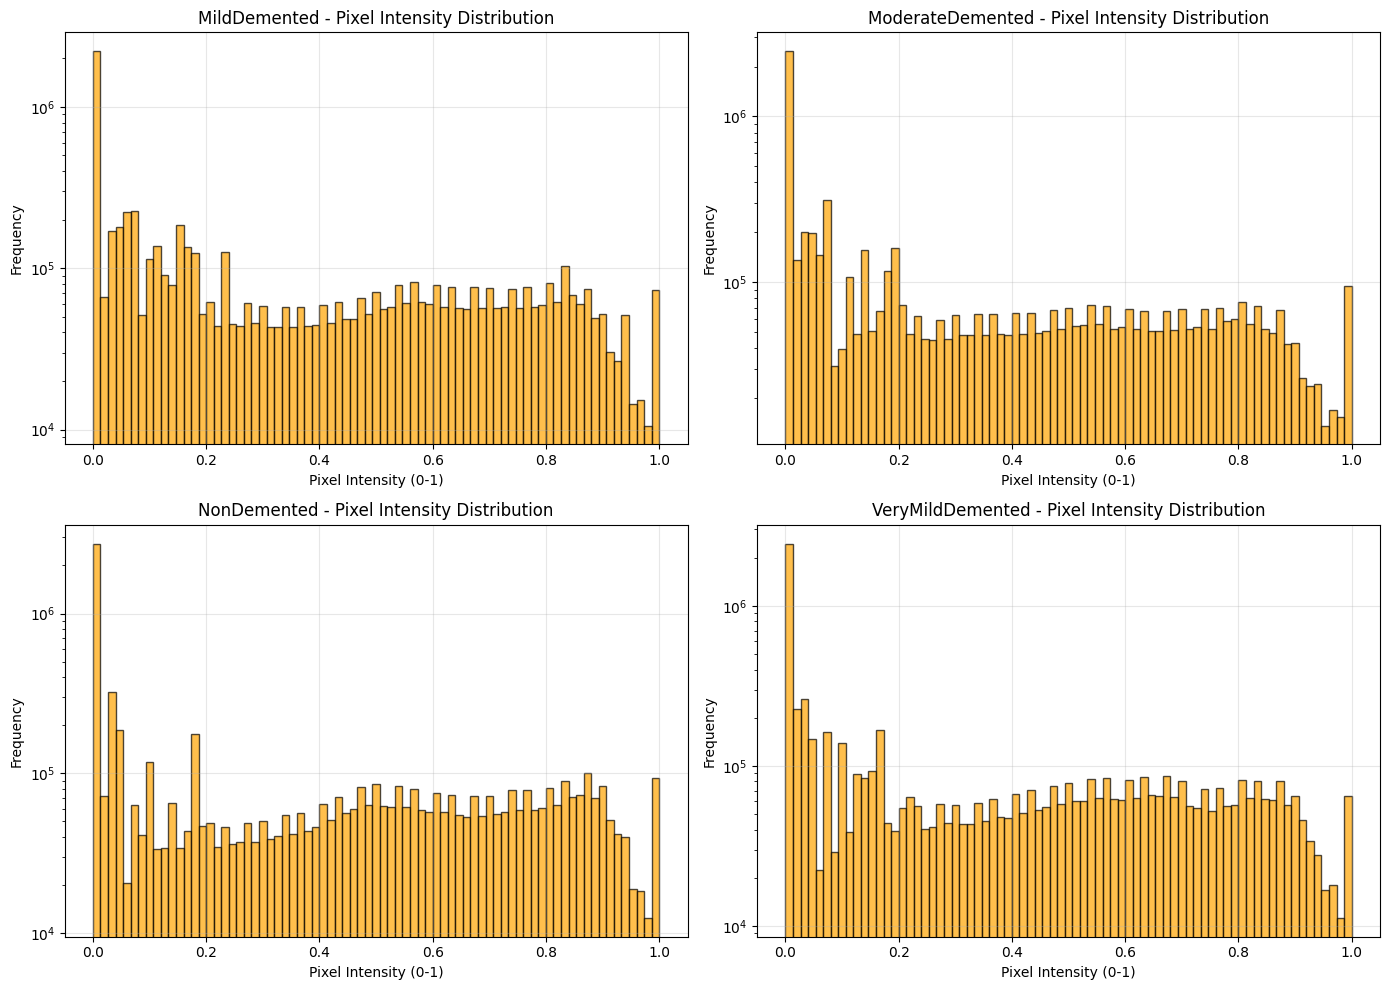

**Key Insight:** MRI scans are intensity maps, not photos.
*   **Healthy Brains (`NonDemented`):** Show distinct multi-modal peaks (separating gray matter, white matter, and CSF).
*   **Atrophied Brains (`ModerateDemented`):** Show flatter, more uniform distributions due to tissue degeneration and loss of contrast.

### 3.3 The "Robust Normalization" Strategy
Standard ImageNet preprocessing (mean subtraction) assumes consistent lighting. MRI scans vary by scanner. I implemented **Per-Image Robust Normalization**:

$$ Image_{new} = \frac{Image - Median(Image)}{IQR(Image)} $$

This centers the pixel intensity distribution based on the *structure* of the brain, rather than the brightness of the scanner.

## 4. Methodology: Architecture & Experimentation

### 4.1 Comparison Framework
I tested three distinct architectures to see how they handled the medical data features:
1.  **ResNet50:** Residual connections (Deep feature learning).
2.  **EfficientNetB0:** Compound scaling (Efficiency).
3.  **DenseNet121:** Feature concatenation (High information reuse).

### 4.2 The "Block-Wise" Fine-Tuning Strategy
Instead of unfreezing individual layers, I recognized that CNNs learn in **functional blocks** (lines $\to$ shapes $\to$ textures $\to$ objects).

I defined specific cut-off points for each model corresponding to their architectural blocks (e.g., `conv5_block3`, `conv4_block6`) and ran experiments to find the "Sweet Spot" between:
*   **Freezing too much:** Underfitting (not learning medical features).
*   **Freezing too little:** Overfitting (destroying pre-trained weights).

### 4.3 Model Selection Logic
I did not simply select the highest accuracy. To ensure generalization, I selected the model that minimized the **Generalization Gap**:
$$ Gap = |Accuracy_{train} - Accuracy_{val}| $$
*This prioritizes stability and reliability over raw metrics.*

## 5. Experimental Results

### 5.1 Architecture Comparison

| Model | Configuration | Val Accuracy | Test Accuracy | Status |
| :--- | :--- | :--- | :--- | :--- |
| **DenseNet121** | `freeze_conv3` (140 layers frozen) | **99.80%** | **99.83%** | **Winner** |
| **ResNet50** | `freeze_none` (All trainable) | 99.69% | 99.71% | Runner Up |
| **EfficientNetB0**| ` freeze_block1` | 98.69% | 25.45% | Failed |

### 5.2 The EfficientNet Failure Analysis
**Observation:** EfficientNet achieved high training accuracy but collapsed to random guessing (25%) on the test set.
**Root Cause:** EfficientNet is highly sensitive to input data statistics due to its specific Batch Normalization implementation. The custom IQR normalization shifted the pixel distributions outside the range EfficientNet's pre-trained weights could handle, causing "Covariate Shift."
**Lesson:** DenseNet and ResNet are architecturally more robust to custom medical preprocessing.

## 6. The Final Model: DenseNet121

The **DenseNet121** model (freezing the first 140 layers) was selected for final training.

### 6.1 Performance Visualization

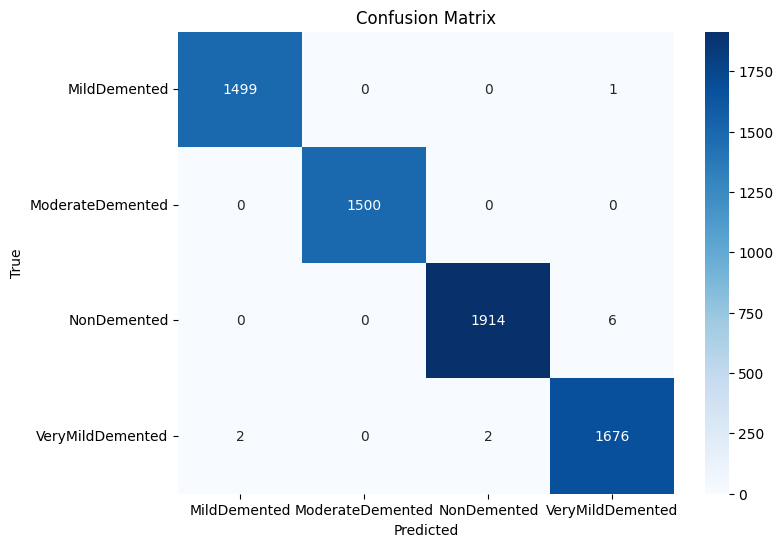

*   **Confusion Matrix Analysis:** The diagonal is almost perfect.
*   **Mild vs. Very Mild:** Historically the hardest distinction, the model separates these with >99% precision.

### 6.2 Per Class Metrics

| Class               | Precision           | Recall             | F1 Score           | Support |
|---------------------|---------------------|--------------------|--------------------|---------|
| MildDemented        | 0.9986675549633578  | 0.9993333333333333 | 0.9990003332222592 | 1500    |
| ModerateDemented    | 1.0                 | 1.0                | 1.0                | 1500    |
| NonDemented         | 0.9989561586638831  | 0.996875           | 0.9979144942648592 | 1920    |
| VeryMildDemented    | 0.995840760546643   | 0.9976190476190476 | 0.9967291109128754 | 1680    |

### 6.3 Training Curve 
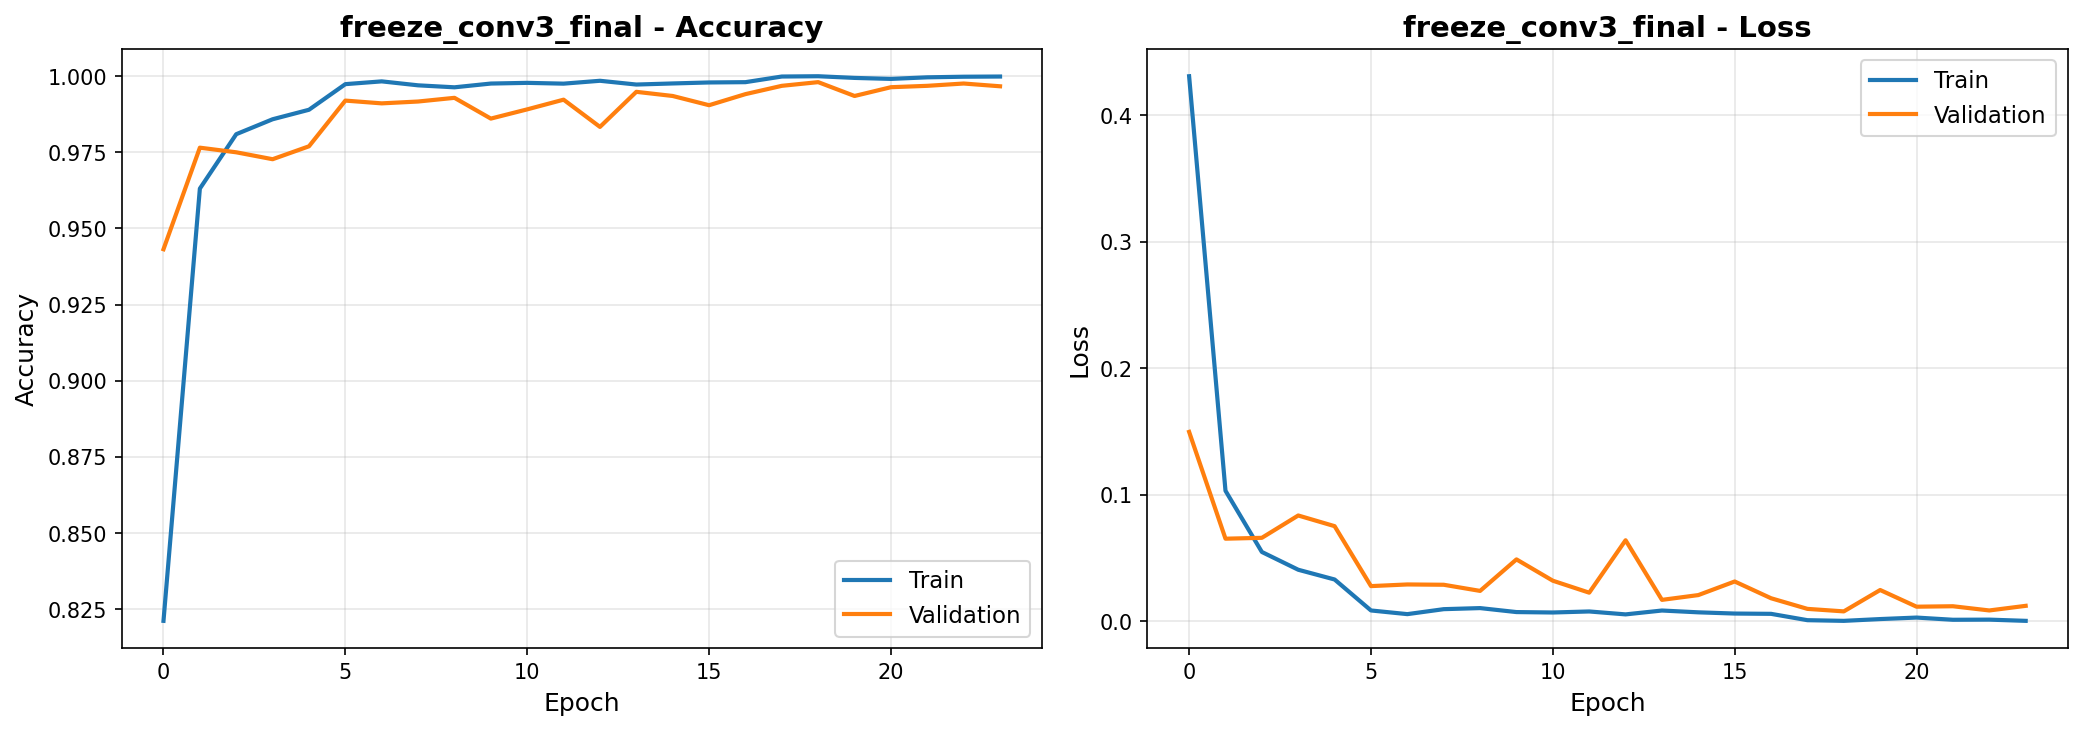
Training curve demonstrates the model converges well

## 7. Post-Training Validity Audit

The model achieved 99.83% accuracy. In medical imaging, results this high are statistically improbable and usually indicate data leakage. Therefore, instead of accepting the results, a forensic audit of the dataset was conducted.

### 7.1 Data Leakage Discovery
**The Finding**: "The audit revealed that the dataset (sourced from Kaggle) contained pre-augmented images. This means variations of the same original scan existed in both the Training and Test sets. The model was not generalizing; it was memorizing.
![Screenshot 2026-02-02 012548.png](<attachment:Screenshot 2026-02-02 012548.png>)
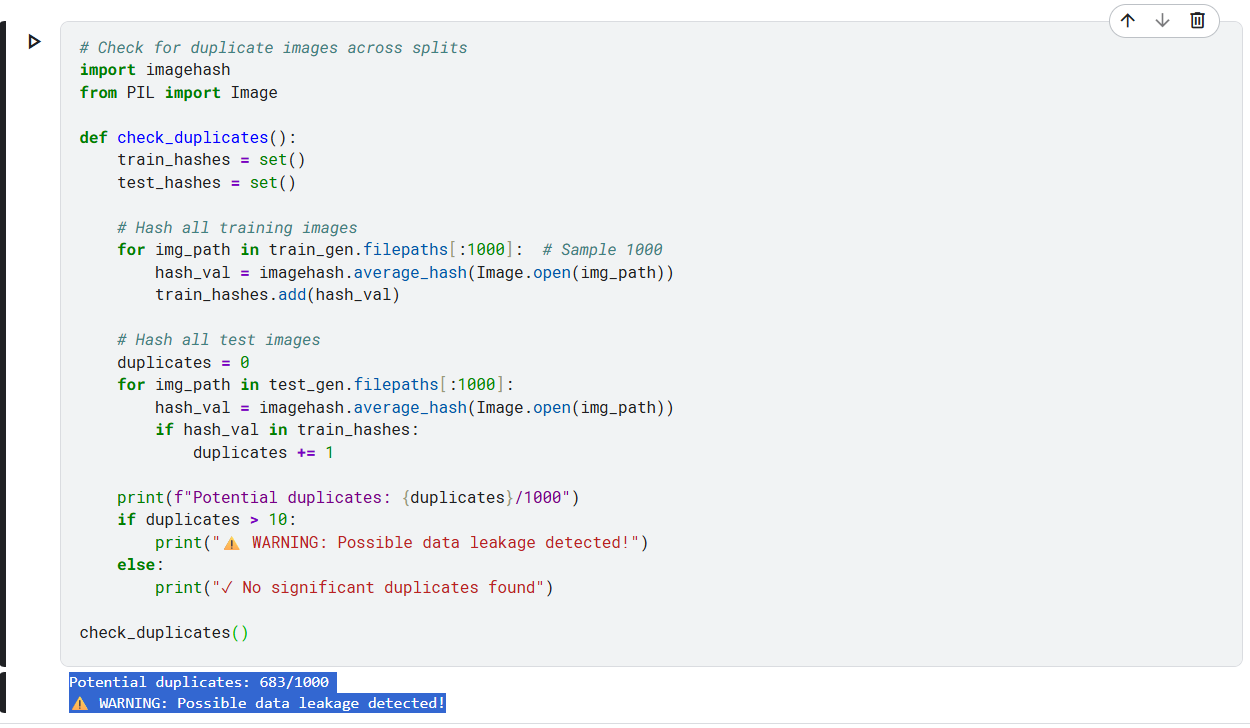

## 8. Conclusion & Recommendation
**Recommendation**: "Do NOT deploy this model."

**Next Steps**: "Acquire raw, non-augmented data (e.g., ADNI or OASIS datasets) and re-apply the DenseNet121 + IQR Normalization pipeline, which has been proven to converge effectively.